**This script is to take in the ouput generated by OA-SLAM and align it with Ground Truth and export both Ground Truth and aligned estimated camera and object poses into a json file.**

## Import Modules

In [1]:
import os
import json
import copy
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from typing import List
import math
from matplotlib.patches import Patch
from distinctipy import get_colors # to get unique colors
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from itertools import product
from numpy.linalg import LinAlgError, eigvalsh

%matplotlib notebook

In [2]:
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# BOP YCBV dataset
dataset_info = {'1': 'master_chef_can',
                '2': 'cracker_box',
                '3': 'sugar_box',
                '4': 'tomato_soup_can',
                '5': 'mustard_bottle',
                '6': 'tuna_fish_can',
                '7': 'pudding_box',
                '8': 'gelatin_box',
                '9': 'potted_meat_can',
                '10': 'banana',
                '11': 'pitcher_base',
                '12': 'bleach_cleanser',
                '13': 'bowl',
                '14': 'mug',
                '15': 'power_drill',
                '16': 'wood_block',
                '17': 'scissors',
                '18': 'large_marker',
                '19': 'large_clamp',
                '20': 'extra_large_clamp',
                '21': 'foam_brick'}

In [4]:
# Folder containing the BOP dataset formated files
gt_data_path = "/home/allen/Desktop/RnD_Github/AllenIsaacRnD/dataset/000009/"
# Folder containing the file generated by OA-SLAM
output_data_path = gt_data_path + "oa_slam_result/"
# Load the GT models
model_path = '/home/allen/Desktop/RnD_Github/AllenIsaacRnD/dataset/'
# Export file data path
export_path = output_data_path

# VISUALISATION FUNCTIONS

## Function to plot ellipsoids

In [5]:
# Reference - https://github.com/qcr/quadricslam/blob/master/src/quadricslam/visualisation.py
def plot_ellipsoid(pose: np.ndarray, radii: np.ndarray, ax: matplotlib.figure.Axes, color):
    # Generate ellipsoid of appropriate size at origin
    SZ = 50
    radii = np.abs(radii)
    u, v = np.linspace(0, 2 * np.pi, SZ), np.linspace(0, np.pi, SZ)
    x, y, z = (radii[0] * np.outer(np.cos(u), np.sin(v)),
               radii[1] * np.outer(np.sin(u), np.sin(v)),
               radii[2] * np.outer(np.ones_like(u), np.cos(v)))

    # Rotate the ellipsoid, then translate to centroid
    ps = pose @ np.vstack([
        x.reshape(-1),
        y.reshape(-1),
        z.reshape(-1),
        np.ones(z.reshape(-1).shape)
    ])

    # Plot the ellipsoid
    ax.plot_wireframe(
        ps[0, :].reshape(SZ, SZ),
        ps[1, :].reshape(SZ, SZ),
        ps[2, :].reshape(SZ, SZ),
        rstride=4,
        cstride=4,
        color=color,
        linewidth=0.5,
    )

## Function to plot cuboids

In [6]:
def plot_cuboid(pose: np.ndarray, size: np.ndarray, ax: matplotlib.figure.Axes, color):
    # Get all 8 corner points of the cuboid
    #vertices = np.array(list(product(*zip(pose[:3, -1] - 0.5 * size, pose[:3, -1] + 0.5 * size))))
    vertices = np.array(list(product(*zip(- 0.5 * size, + 0.5 * size))))
    
    # Transform the cuboid's vertices using the pose matrix
    t_vertices = np.dot(pose[:3, :3], vertices.T).T + pose[:3, -1]
    
    # Define the edges of the cuboid using the vertices
    edges = [
        [t_vertices[0], t_vertices[1]], [t_vertices[1], t_vertices[5]], [t_vertices[5], t_vertices[4]],
        [t_vertices[4], t_vertices[0]], [t_vertices[7], t_vertices[6]], [t_vertices[6], t_vertices[2]],
        [t_vertices[2], t_vertices[3]], [t_vertices[3], t_vertices[7]], [t_vertices[0], t_vertices[2]],
        [t_vertices[1], t_vertices[3]], [t_vertices[4], t_vertices[6]], [t_vertices[5], t_vertices[7]]
    ]
    
    ax.add_collection3d(Line3DCollection(edges, colors=color, linewidths=2))

## Function to plot trajectory

In [7]:
def plot_traj(data: List, ax: matplotlib.figure.Axes, length = 50, c:str = 'cyan', label = None):
    
    # to plot trajectory
    traj = []
    
    for idx in range(len(data)):
        # position
#         ax.scatter(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1], c='r', marker='*')
        # orientation
        if idx % 30 == 0:
            # X
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 0], data[idx][1, 0], data[idx][2, 0],
                      color='r', length=length, linewidth=0.2, alpha=1)
            # Y
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 1], data[idx][1, 1], data[idx][2, 1],
                      color='g', length=length, linewidth=0.2, alpha=1)
            # Z
            ax.quiver(data[idx][0,-1], data[idx][1,-1], data[idx][2,-1],
                      data[idx][0, 2], data[idx][1, 2], data[idx][2, 2],
                      color='b', length=length, linewidth=0.2, alpha=1)
        
        traj.append([data[idx][0,-1], data[idx][1,-1], data[idx][2,-1]])
        
    #trajectory
    if c != 'cyan':
        traj = np.array(traj)
        if label==None:
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=c)
        else:
            ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=c, label = label)
        
    
    return None

# GROUND TRUTH

## Ground Truth Camera Poses

In [8]:
f = open(gt_data_path + 'scene_camera.json')
camera_pose = json.load(f)

In [9]:
camera_pose['1']

{'cam_K': [888.888916015625, 0.0, 320.0, 0.0, 1000.0, 240.0, 0.0, 0.0, 1.0],
 'cam_R_w2c': [-0.004491119476015593,
  0.9999899029304199,
  -1.4025850225172284e-07,
  0.384611486719493,
  0.0017272239408220326,
  -0.923076946949622,
  -0.923067626092874,
  -0.004145702431382654,
  -0.3846153392417822],
 'cam_t_w2c': [-5.395761028208294e-06,
  3.8963063781735155e-05,
  1299.9999839746856],
 'depth_scale': 10}

### Plotting Ground Truth Camera Trajectory

<IPython.core.display.Javascript object>


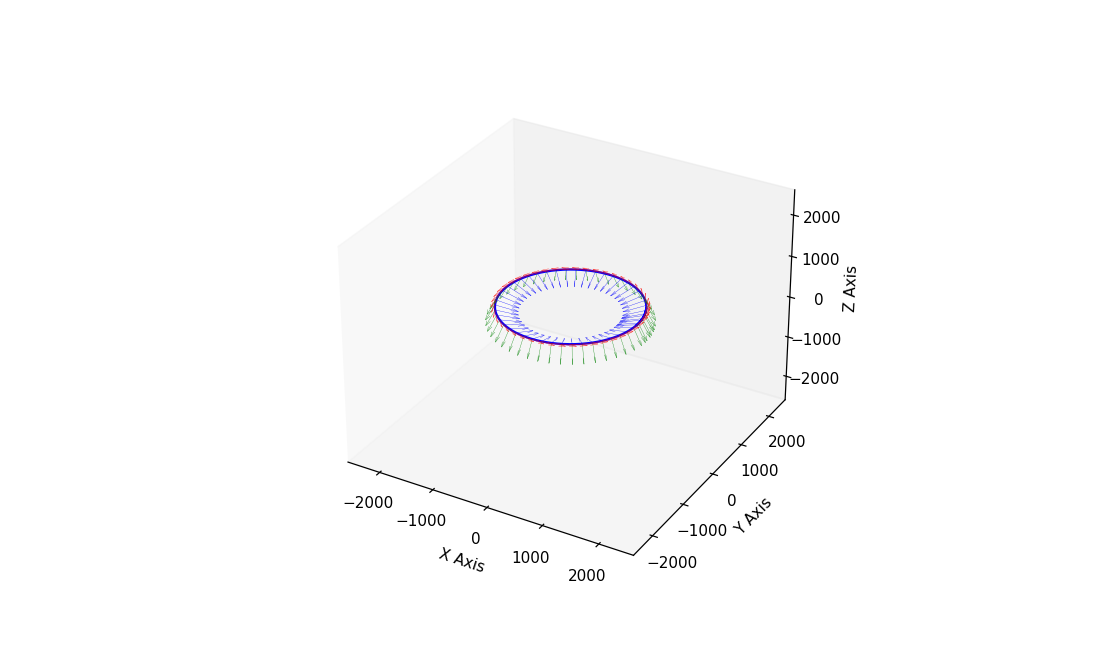

In [10]:
gt_traj = []

for c in camera_pose:
    
    world2camera = np.column_stack((np.array(camera_pose[c]['cam_R_w2c']).reshape(3,3),
                                    np.array(camera_pose[c]['cam_t_w2c']).reshape(3,1)))
    world2camera = np.row_stack((world2camera, np.array([0. , 0., 0., 1.])))
    
    # In the dataset, the transformation is w2c(world with respect to the camera)
    # we need to change it to camera with respect to the world.
    gt_traj.append(np.linalg.inv(world2camera))


fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlim((-2500, 2500))
ax.set_ylim((-2500, 2500))
ax.set_zlim((-2500, 2500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')


plot_traj(gt_traj, ax, length=400, c = 'blue')

ax.grid(False)

plt.show()

## GT Object pose

In [11]:
f = open(gt_data_path + 'scene_gt.json')
object_pose = json.load(f)

In [12]:
object_pose['1']

[{'cam_R_m2c': [-0.004491119476015593,
   0.9999899029304199,
   -1.39991281351308e-07,
   0.384611486719493,
   0.0017272239408220326,
   -0.9213182981051237,
   -0.923067626092874,
   -0.004145702431382654,
   -0.3838825689953048],
  'cam_t_m2c': [34.82767932111333, -9.457532342334977, 1088.117014047327],
  'obj_id': 10,
  'obj_name': 'banana'},
 {'cam_R_m2c': [-0.004491119476015593,
   0.9999899029304199,
   -1.400886258690289e-07,
   0.384611486719493,
   0.0017272239408220326,
   -0.9219589471836288,
   -0.923067626092874,
   -0.004145702431382654,
   -0.3841495060729541],
  'cam_t_m2c': [176.96946571382256, -12.310938509494218, 1225.7100592087272],
  'obj_id': 21,
  'obj_name': 'foambrick'},
 {'cam_R_m2c': [-0.004491119476015593,
   0.9999899029304199,
   -1.4017973378333002e-07,
   0.384611486719493,
   0.0017272239408220326,
   -0.9225585515856856,
   -0.923067626092874,
   -0.004145702431382654,
   -0.3843993412045431],
  'cam_t_m2c': [134.64676712430136, -123.31148708683776, 

### Loading Models and Assigning Colors

In [13]:
f = open(model_path + 'models_info.json')
model_data = json.load(f)

classes = []

for o in range(len(object_pose['1'])):
    classes.append(object_pose['1'][o]['obj_id'])
    
colors = get_colors(len(object_pose['1']))

### Plotting Ground Truth Camera Trajectory and objects

#### Taking all possible object poses

<IPython.core.display.Javascript object>


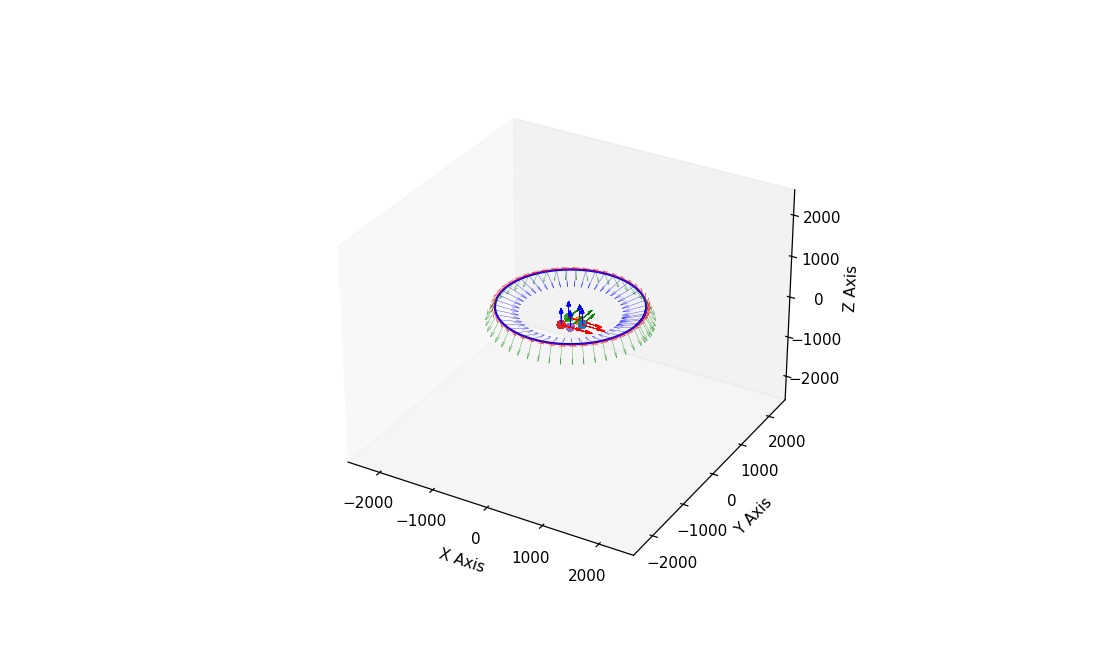

In [14]:
# all object poses
gt_pose_data_all = [[] for _ in range(len(object_pose['1']))]

idx = 0
for c in camera_pose:

    for o in range(len(object_pose['1'])):
        
        object2camera = np.column_stack((np.array(object_pose[c][o]['cam_R_m2c']).reshape(3,3),
                                         np.array(object_pose[c][o]['cam_t_m2c']).reshape(3,1)))
        object2camera = np.row_stack((object2camera, np.array([0. , 0., 0.,1.])))
        
        # given W with respect to C and M with respect to C
        # We need M with respect to W. In other words,
        # we need W_T_M = inv(C_T_W) @ C_T_M = W_T_C @ C_T_M 
        gt_pose_data_all[o].append(np.dot(gt_traj[idx], object2camera))
             
    idx+=1
    

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-2500, 2500))
ax.set_ylim((-2500, 2500))
ax.set_zlim((-2500, 2500))
plot_traj(gt_traj, ax, length=400, c = 'blue')

# plotting as poses
for o in range(len(object_pose['1'])):
    plot_traj(gt_pose_data_all[o], ax, length=400)


# plotting as points
for o in range(len(object_pose['1'])):
    subset_t = np.array([l[:3, -1] for l in gt_pose_data_all[o]])
    ax.scatter(subset_t[:, 0], subset_t[:, 1], subset_t[:, 2])

ax.grid(False)

plt.show()


#### Averaging and taking a single object pose

<IPython.core.display.Javascript object>


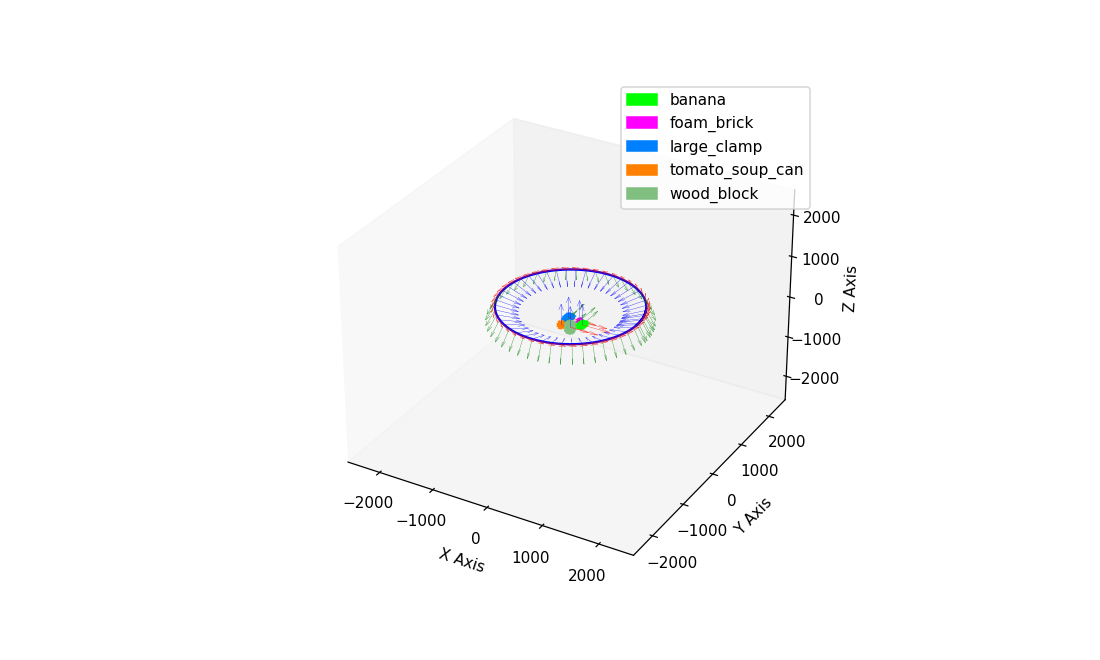

In [42]:

gt_pose = []

for obj in gt_pose_data_all:
    arrays_stack = np.stack(obj)
    gt_pose.append(np.mean(arrays_stack, axis=0))
    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-2500, 2500))
ax.set_ylim((-2500, 2500))
ax.set_zlim((-2500, 2500))
plot_traj(gt_traj, ax, length=400, c = 'blue')

# plotting as poses
for o in range(len(object_pose['1'])):
    plot_traj([gt_pose[o]], ax, length=500)
    

# plotting as ellipsoids and cuboids
for o in range(len(object_pose['1'])):
    class_id = str(classes[o])
    radii = np.array([model_data[class_id]['size_x'],
                      model_data[class_id]['size_y'],
                      model_data[class_id]['size_z']])
    # plotting as ellipsoids
    plot_ellipsoid(gt_pose[o], radii/2, ax, colors[o])
    # plotting as cuboids
    plot_cuboid(gt_pose[o], radii, ax, colors[o])
    
ax.legend(handles=[
        Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
    ])
ax.grid(False)
plt.show()

# OUTPUT DATA PROCESSING

### OA-SLAM dual quadrics decomposition function

In [16]:
# takes in the dual quadric matrix representation
# ouputs -> 4x4 transformation matrix, radius
def decompose(dual_quadrics:np.ndarray):
    
    center = -dual_quadrics[:, 3][:3]

    T_c = np.eye(4)
    T_c[0, 3] = -center[0]
    T_c[1, 3] = -center[1]
    T_c[2, 3] = -center[2]
    temp = T_c @ dual_quadrics @ T_c.T
    pose_center = 0.5 * (temp + temp.T)

    try:
        eig_values = eigvalsh(pose_center[:3, :3])
        eig_vectors = np.linalg.eigh(pose_center[:3, :3])[1]
    except LinAlgError:
        raise ValueError("Matrix is not positive definite. Decomposition failed.")

    if np.linalg.det(eig_vectors) < 0.0:
        eig_vectors[:, 2] *= -1

    axes = np.sqrt(np.abs(eig_values))
    R = eig_vectors
    has_changed = False
    
    pose = np.eye(4)
    pose[:3, -1] = T_c[:3, -1]
    pose[:3, :3] = R
    
    return pose, axes

## Reading Output File



### Estimated Camera Poses from camera_poses_sink.txt

In [17]:
unaligned_traj = []

dataset_id = os.path.basename(os.path.dirname(output_data_path[:-1]))

with open(output_data_path + 'camera_poses_' + dataset_id + '.txt', 'r') as file:
    for line in file:
        l = line.strip()
        as_float = [float(e) for e in l.split()]
        as_float = as_float[1:]
        as_nparray = np.array(as_float).reshape(3,4)
        as_nparray = np.vstack((as_nparray, np.array([0, 0, 0, 1])))
        unaligned_traj.append(as_nparray)

In [18]:
unaligned_traj

[array([[ 1.,  0.,  0., -0.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.]]),
 array([[ 1.,  0.,  0., -0.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.]]),
 array([[ 1.,  0.,  0., -0.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.]]),
 array([[ 1.,  0.,  0., -0.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.]]),
 array([[ 1.,  0.,  0., -0.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.]]),
 array([[ 1.,  0.,  0., -0.],
        [ 0.,  1.,  0., -0.],
        [ 0.,  0.,  1., -0.],
        [ 0.,  0.,  0.,  1.]]),
 array([[ 9.99634e-01,  9.00782e-03, -2.55169e-02,  2.36574e-02],
        [-9.00259e-03,  9.99959e-01,  3.19800e-04, -3.53855e-04],
        [ 2.55188e-02, -8.99641e-05,  9.99674e-01, -1.02413e-04],
        [ 0.00000e+00,  0.00000e+00,  0.00000e+00,  1.00000e+00]]),
 a

### Estimated Object Poses from map_objects_sink.txt

In [19]:
unaligned_quad = []

# QUADRIC ID, CATEGORY ID, 4X4 matrix
with open(output_data_path + 'map_objects_' + dataset_id + '.txt', 'r') as file:
    for line in file:
        l = line.strip()
        as_float = [float(e) for e in l.split()]
        as_nparray = np.array(as_float[2:]).reshape(4,4)
        temp = dict()
        temp['quadric_id'] = as_float[0]
        temp['category_id'] = as_float[1]
        temp['pose'] = as_nparray
        temp['pose'][:, -1] = temp['pose'][:, -1] * (-1)
        unaligned_quad.append(temp)

        
##### IN THE NEW DATASET GROUND TRUTH INFO, ORDER IS NOT ASCENDING

# sort based on the object indices of the ground truth
# sort the estimated objects in ascending order
unaligned_quad = sorted(unaligned_quad, key=lambda x: x['category_id'])
# get the order of ground truth
sorted_indices = sorted(range(len(classes)), key=lambda i: classes[i])

final = [i for i in range(len(unaligned_quad))]
for i in range(len(unaligned_quad)):
    final[sorted_indices[i]] = unaligned_quad[i]
    
unaligned_quad = final


#unaligned_quad = sorted(unaligned_quad, key=lambda x: x['category_id'])

### Plotting Estimated Trajectory and Object

<IPython.core.display.Javascript object>


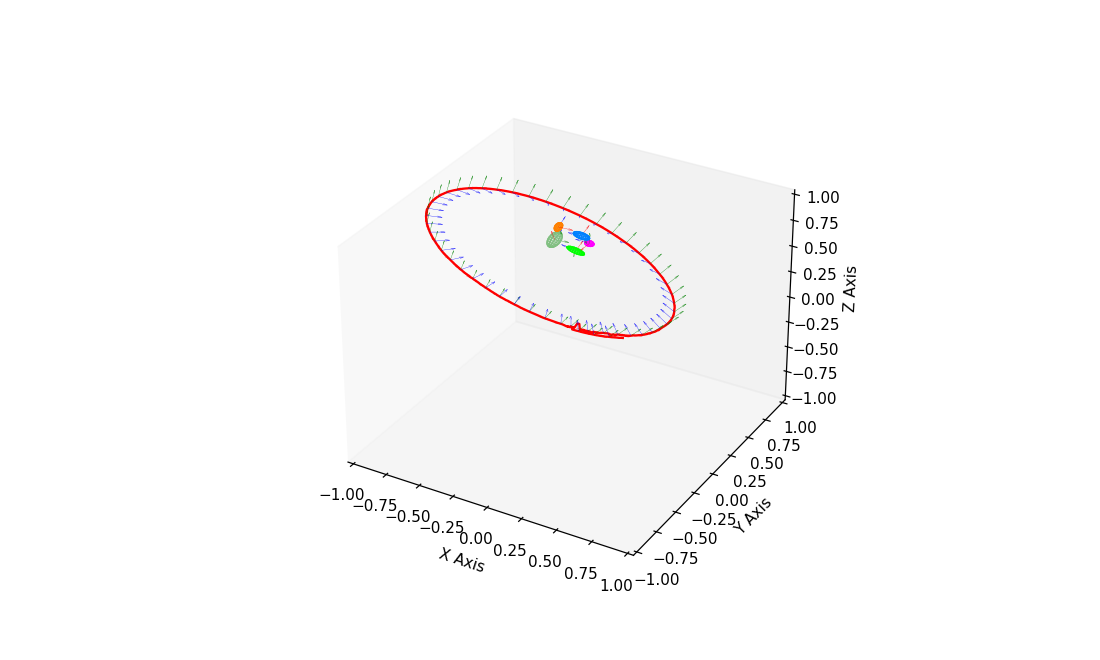

In [20]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-1, 1))
ax.set_ylim((-1, 1))
ax.set_zlim((-1, 1))

### PLOT TRAJECTORY ###
plot_traj(unaligned_traj, ax, length=0.1, c = 'red')

### PLOT OBJECT AS ELLIPSOID ###
for o in range(len(unaligned_quad)):
    class_id = unaligned_quad[o]['category_id']
    # pose, radii
    pose, radii = decompose(unaligned_quad[o]['pose'])
    plot_ellipsoid(pose, radii, ax, colors[classes.index(class_id)])
    plot_traj([pose], ax, length=0.1)


ax.grid(False)

plt.show()

## Aligning the estimated poses with the ground truth poses




### Aligning the GT camera pose with origin

In [21]:
origin_gt_traj = []

gt_traj_origin = np.linalg.inv(gt_traj[0])

for traj in gt_traj:
    origin_gt_traj.append(np.dot(gt_traj_origin, traj))

### Aligning the estimated camera pose with origin

In [22]:
origin_aligned_traj = []

est_traj_origin = np.linalg.inv(unaligned_traj[0])

for traj in unaligned_traj:
    origin_aligned_traj.append(np.dot(est_traj_origin, traj))

### Aligning the GT object pose with origin

In [23]:
origin_gt_quad = []

for pose in gt_pose:
    origin_gt_quad.append(np.dot(gt_traj_origin, pose))

### Aligning the estimated object pose with origin

In [24]:
origin_aligned_quad = []

for o in range(len(unaligned_quad)):
    temp = dict()
    
    temp['quadric_id'] = unaligned_quad[o]['quadric_id']
    
    class_id = unaligned_quad[o]['category_id']
    temp['category_id'] = class_id

    # pose, radii
    pose, radii = decompose(unaligned_quad[o]['pose'])
    temp['pose'] = np.dot(est_traj_origin, pose)
    temp['radii'] = radii
    
    origin_aligned_quad.append(temp)



### Finding the scaling factor

#### USING OBJECT DIMENSIONS

In [25]:
## Input a list and percentile to consider what to be an outlier
def outlier_detection(data:list, low_percentile:int, upp_percentile:int):

    # Calculate the median and IQR
    median = np.median(data)
    q1 = np.percentile(data, low_percentile)
    q3 = np.percentile(data, upp_percentile)
    iqr = q3 - q1

    # Define a threshold for outlier detection
    threshold = 1.5

    # Identify potential outliers
    potential_outliers = [x for x in data if x < q1 - threshold * iqr or x > q3 + threshold * iqr]

    return potential_outliers

In [26]:
## stores the 3 Radii of each GT object as a numpy array within a list
gt_sizes = []

for o in range(len(gt_pose)):
    class_id = str(classes[o])
    radii = np.array([model_data[class_id]['size_x']/2,
                     model_data[class_id]['size_y']/2,
                     model_data[class_id]['size_z']/2])
    gt_sizes.append(radii)

    
## stores the 3 Radii of each estimated object as a numpy array within a list
est_sizes = []
for o in range(len(unaligned_quad)):
    _, axes = decompose(unaligned_quad[o]['pose'])
    est_sizes.append(axes)


## divide the radii of the ground truth object with the estimated object
## take the average of the 3 ratios corresponding to each dimension
ratios = []
for o in range(len(gt_pose)):
    ratio = gt_sizes[o]/est_sizes[o]
    ratios.append(sum(ratio)/len(ratio))

## find which is better
outliers1 = outlier_detection(ratios, 25, 50)
ratio1 = [x for x in ratios if x not in outliers1]
ratio_obj_1 = sum(ratio1)/len(ratio1)

outliers2 = outlier_detection(ratios, 25, 75)
ratio2 = [x for x in ratios if x not in outliers2]
ratio_obj_2 = sum(ratio2)/len(ratio2)

## two hypothesis
print(ratio_obj_1, ratio_obj_2)

1317.138130722927 1561.874425998357


#### USING TRAJECTORY DIMENSIONS

In [27]:
## ratios of last count number of trajectories
## dividing x,y,z of ground truth trajectory and estimated trajectory
count = 50
trans_ratios = []
for t in range(1, count+1):
    trans_ratios.append(origin_gt_traj[-t][:3, -1]/origin_aligned_traj[-t][:3, -1])
    
trans_ratios = np.array(trans_ratios)

## 2nd dimension is depth which is very much erroneous
## taking x and y which is first and last dimensions
ratio_traj_1 = np.mean(trans_ratios, axis=0)[0]
ratio_traj_2 = np.mean(trans_ratios, axis=0)[2]
ratio_traj_3 = (ratio_traj_1 + ratio_traj_2)/2

## three hypothesis
print(ratio_traj_1, ratio_traj_2, ratio_traj_3)

1294.2444548197477 2930.8544268671562 2112.549440843452


In [28]:
# ratio_obj_1, ratio_obj_2, ratio_traj_1, ratio_traj_2, ratio_traj_3
# The ratios obtained from objects are better than the ratio from trajcetories
scale = abs(ratio_obj_2) ## seems to have better object error metrics
scale

1561.874425998357


### Scaling the estimated camera pose

In [29]:
scaled_origin_aligned_traj = []

for traj in origin_aligned_traj:
    updated_translation = traj[:3, -1] * scale
    T = np.eye(4)
    T[:3, :3] = traj[:3, :3]
    T[:3, -1] = updated_translation
    scaled_origin_aligned_traj.append(T)


### Scaling the estimated object pose

In [30]:
scaled_origin_aligned_quad = []

for o in range(len(origin_aligned_quad)):
    temp = dict()
    
    temp['quadric_id'] = origin_aligned_quad[o]['quadric_id']
    
    class_id = origin_aligned_quad[o]['category_id']
    temp['category_id'] = class_id

    # pose, radii
    pose = origin_aligned_quad[o]['pose']
    pose[:3, -1] *= scale
    temp['pose'] = pose
    
    radii = origin_aligned_quad[o]['radii']
    radii *= scale
    temp['radii'] = radii
    
    scaled_origin_aligned_quad.append(temp)


### Aligning the estimated camera pose with ground truth

In [31]:
aligned_traj = []

for traj in scaled_origin_aligned_traj:
    aligned_traj.append(np.dot(gt_traj[0], traj))

### Further alignment using OPEN3D - ICP

In [32]:
## Get the 3D points
points_gt = []
points_est = []

for i in range(len(gt_traj)):
    points_gt.append(list(gt_traj[i][:3, 3]))
    points_est.append(list(aligned_traj[i][:3, 3]))
    
points_gt = np.array(points_gt)
points_est = np.array(points_est)


# Define or load your 3D point clouds as numpy arrays: cloud_source_np and cloud_target_np

# Convert numpy arrays to Open3D point cloud objects
cloud_source = o3d.geometry.PointCloud()
cloud_source.points = o3d.utility.Vector3dVector(points_est)

cloud_target = o3d.geometry.PointCloud()
cloud_target.points = o3d.utility.Vector3dVector(points_gt)

# Perform ICP registration
icp_result = o3d.pipelines.registration.registration_icp(
    cloud_source, cloud_target, max_correspondence_distance=1000,
    estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint())

# Get the optimized transformation matrix
transformation_matrix = icp_result.transformation

## WAY 1 TO VISUALIZE
# # Apply the transformation to the source cloud to align it with the target
# cloud_source.transform(transformation_matrix)
# points_est = np.asarray(cloud_source.points)

# # Visualize the aligned point clouds
# o3d.visualization.draw_geometries([cloud_source, cloud_target])


## WAY 2 TO VISUALIZE
# # Add a column of ones to the points to make them homogeneous coordinates (4xN)
# points_homogeneous = np.column_stack((points_est, np.ones(points_est.shape[0])))

# # Multiply the points by the transformation matrix to apply the transformation
# transformed_points_homogeneous = np.dot(transformation_matrix, points_homogeneous.T).T

# # Extract the transformed 3D points (remove the homogeneous coordinate)
# transformed_points = transformed_points_homogeneous[:, :3]

# points_est = transformed_points.copy()

In [33]:
## applying transformation on the estimated trajectory

for x in range(len(aligned_traj)):
    aligned_traj[x] = np.dot(transformation_matrix, aligned_traj[x])

### Plotting Aligned Estimated Camera Pose and Ground Truth Camera Pose

<IPython.core.display.Javascript object>


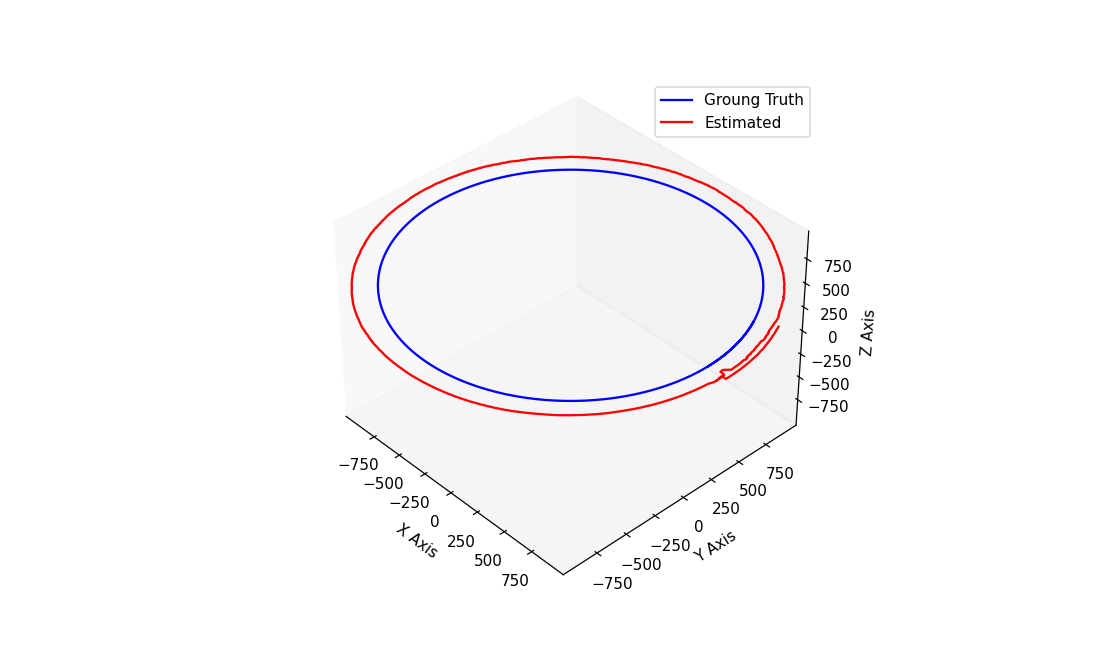

In [43]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-2500, 2500))
ax.set_ylim((-2500, 2500))
ax.set_zlim((-2500, 2500))

plot_traj(gt_traj, ax, length=400, c = 'blue', label="Groung Truth")
plot_traj(aligned_traj, ax, length=400, c = 'red', label="Estimated")

plt.legend()
ax.grid(False)

plt.show()

### Aligning the estimated object pose with ground truth

In [35]:
aligned_quad = []

for o in range(len(scaled_origin_aligned_quad)):
    temp = dict()
    
    temp['quadric_id'] = scaled_origin_aligned_quad[o]['quadric_id']
    
    class_id = scaled_origin_aligned_quad[o]['category_id']
    temp['category_id'] = class_id

    # pose, radii
    pose = scaled_origin_aligned_quad[o]['pose']
    temp['pose'] = np.dot(gt_traj[0], pose) ## first alignment with ground truth
    temp['pose'] = np.dot(transformation_matrix, temp['pose']) ## second alignment with ICP
    

    temp['radii'] = scaled_origin_aligned_quad[o]['radii']
    
    aligned_quad.append(temp)

### Plotting Aligned Estimated Object Pose and Ground Truth Object Pose

<IPython.core.display.Javascript object>


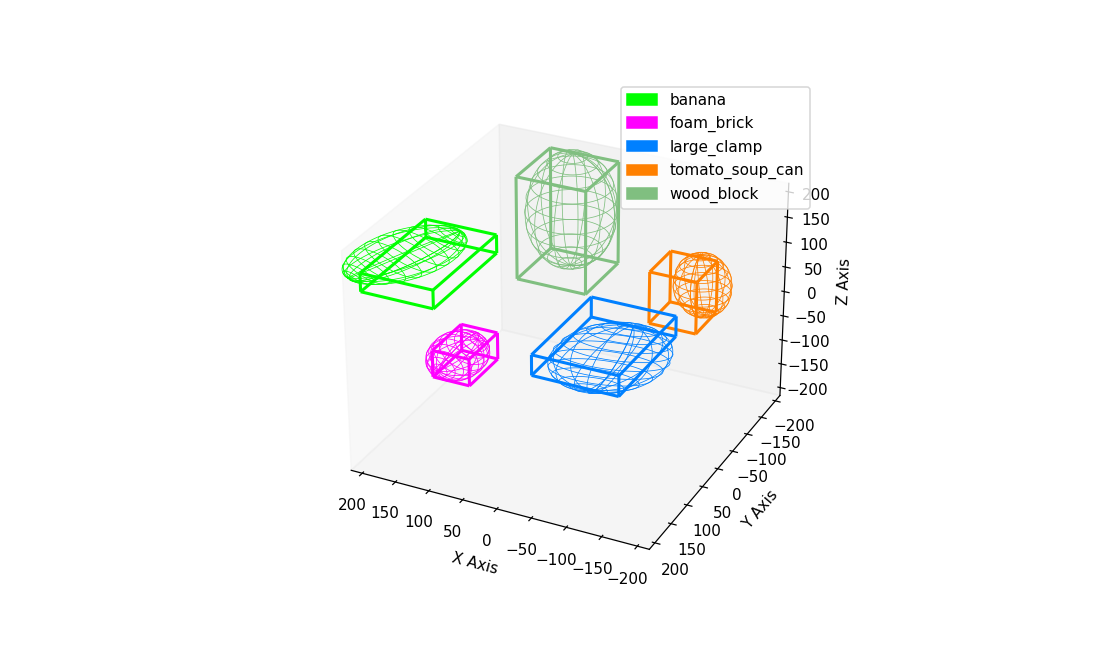

In [44]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-1000, 1000))
ax.set_ylim((-1000, 1000))
ax.set_zlim((-1000, 1000))


##### Ground Truth  ##### 
for o in range(len(gt_pose)):
    class_id = str(classes[o])
    radii = np.array([model_data[class_id]['size_x'],
                      model_data[class_id]['size_y'],
                      model_data[class_id]['size_z']])
    # plotting as ellipsoids
    #plot_ellipsoid(origin_gt_pose[o], radii/2, ax, colors[o])
    # plotting as cubods
    plot_cuboid(gt_pose[o], radii, ax, colors[o])
    # plot the axis
    #plot_traj([gt_pose[o]], ax, length=400)

    
##### Output Quadrics #####     
for o in range(len(aligned_quad)):
    class_id = aligned_quad[o]['category_id']
    pose = aligned_quad[o]['pose']
    radii = aligned_quad[o]['radii']
    plot_ellipsoid(pose, radii, ax, colors[classes.index(class_id)])
    #plot_traj([pose], ax, length=400)


ax.legend(handles=[
        Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
    ])


ax.grid(False)

plt.show()

## Plot Trajectory and Object Pose for Ground Truth and Estimated Aligned

<IPython.core.display.Javascript object>


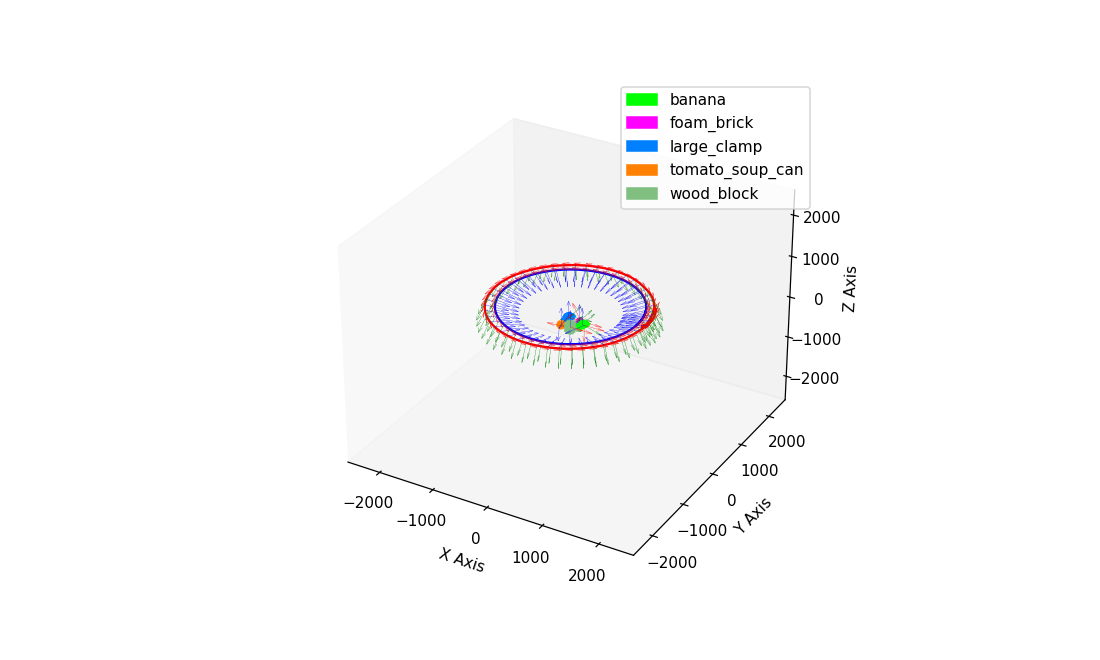

In [37]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Z Axis')
# ax.set_zlabel('Y Axis')
# ax.set_xlim((-700, 100))
# ax.set_ylim((-800, 200))
# ax.set_zlim((-100, 500))
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_xlim((-2500, 2500))
ax.set_ylim((-2500, 2500))
ax.set_zlim((-2500, 2500))


##### TRAJECTORIES #####
plot_traj(gt_traj, ax, length=400, c = 'blue', label="Groung Truth")
plot_traj(aligned_traj, ax, length=400, c = 'red', label="Estimated")



##### QUADRICS #####
##### Ground Truth  ##### 
for o in range(len(gt_pose)):
    class_id = str(classes[o])
    radii = np.array([model_data[class_id]['size_x'],
                      model_data[class_id]['size_y'],
                      model_data[class_id]['size_z']])
    # plotting as ellipsoids
    #plot_ellipsoid(origin_gt_pose[o], radii/2, ax, colors[o])
    # plotting as cubods
    plot_cuboid(gt_pose[o], radii, ax, colors[o])
    # plot the axis
    plot_traj([gt_pose[o]], ax, length=400)
    
##### Output Quadrics #####     
for o in range(len(aligned_quad)):
    class_id = aligned_quad[o]['category_id']
    pose = aligned_quad[o]['pose']
    radii = aligned_quad[o]['radii']
    plot_ellipsoid(pose, radii, ax, colors[classes.index(class_id)])
    plot_traj([pose], ax, length=400)

ax.legend(handles=[
        Patch(facecolor=c, edgecolor=c, label=dataset_info[str(l)]) for l, c in zip(classes, colors)
    ])


ax.grid(False)

plt.show()

# Processed data


- **Ground truth trajectory/camera poses** -> gt_traj(list(np.ndarray))
- **Ground truth object poses** -> gt_pose(list(np.ndarray)) -> radius from model_data[class_id]['size_x']/2, model_data[class_id]['size_y']/2, model_data[class_id]['size_z']/2


- **Estimated trajectory/camera poses** -> aligned_traj(list(np.ndarray))
- **Estimated object poses** -> aligned_quad(list(dict of quadric id, class id and their pose, radius))

# Export data

In [38]:
export_data = {'ground_truth_camera_pose': [],
               'ground_truth_object_pose': dict(),
               'estimated_camera_pose': [],
               'estimated_object_pose': dict()}

## CAMERA POSES
for item in gt_traj:
    export_data['ground_truth_camera_pose'].append(item.tolist())
for item in aligned_traj:
    export_data['estimated_camera_pose'].append(item.tolist())


## GT OBJECT POSE
export_data['ground_truth_object_pose']['pose'] = []
for item in gt_pose:
    export_data['ground_truth_object_pose']['pose'].append(item.tolist())
    
export_data['ground_truth_object_pose']['radius'] = []
export_data['ground_truth_object_pose']['label'] = classes

for o in range(len(object_pose['1'])):
    class_id = str(classes[o])
    radii = [model_data[class_id]['size_x']/2,
             model_data[class_id]['size_y']/2,
             model_data[class_id]['size_z']/2]
    export_data['ground_truth_object_pose']['radius'].append(radii)
    

## ESTIMATED OBJECT POSE
export_data['estimated_object_pose']['pose'] = []
export_data['estimated_object_pose']['radius'] = []
export_data['estimated_object_pose']['label'] = []


for o in range(len(aligned_quad)):
    export_data['estimated_object_pose']['pose'].append(aligned_quad[o]['pose'].tolist())
    export_data['estimated_object_pose']['radius'].append(aligned_quad[o]['radii'].tolist())
    export_data['estimated_object_pose']['label'].append(aligned_quad[o]['category_id'])
    

In [39]:
with open(export_path + 'aligned_output_oslam.json', "w") as json_file:
    json.dump(export_data, json_file, indent=4)  # indent for pretty formatting